# 🚀 Mini-Projet : Système de suivi et d'analyse des transports en commun avec Cassandra et Digitransit
## Equipe


Oussama BOUACEM
Ikram Bourai
Hamza DAHCHOUR

## 📌 Architecture du Projet
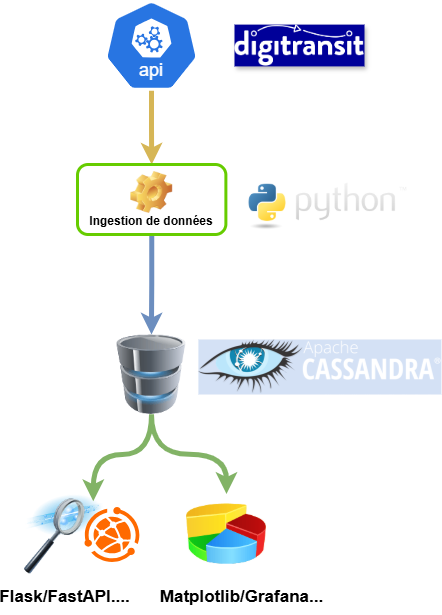

## 🏗 1. Modélisation des Données dans Cassandra
Données collectées depuis Digitransit
L’API de Digitransit fournit des informations en temps réel sur les transports publics :

Horaires des bus/trains
Position GPS des véhicules
Arrêts et itinéraires
Prévisions d’arrivée
Requêtes et Modèle de Données
Nous allons concevoir 3 à 5 requêtes et une modélisation adaptée dans Cassandra.

### 🔍 Requête 1 : Obtenir la position actuelle d'un bus donné
### 🔍 Requête 2 : Consulter les prochains passages à un arrêt donné
### 🔍 Requête 3 : Historique des retards par ligne
### 🔍 Requête 4 : Nombre de trajets effectués par ligne par jour

## ⚡ 2. Ingestion des Données depuis Digitransit
Technologies utilisées :
- Python : pour interroger l’API Digitransit. (une partie du code est fournie)
- Cassandra : pour stocker les données.

## 📊 3. Accès et Visualisation des Données

- Une API REST pour récupérer les données de Cassandra
- Visualisation des données

### Installer le client Python pour MQTT

In [52]:
!pip install paho-mqtt


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### Exécuter cette cellule pour vérifier la réception de messages 

**Attention :** Le programme doit être arrêté manuellement.

## Test MQTT 

In [53]:
import time
from paho.mqtt import client as mqtt_client

# Paramètres MQTT
broker = 'mqtt.hsl.fi'
port = 1883
topic_test = "/hfp/v2/journey/ongoing/vp/test"
client_id = "MQTT-Python-Test"

def connect_mqtt() -> mqtt_client.Client:
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print(" Connecté au broker MQTT!")
        else:
            print(f" Échec de connexion, code {rc}")

    #  Ne pas spécifier callback_api_version ni transport
    client = mqtt_client.Client(client_id=client_id)  
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

def subscribe(client: mqtt_client.Client):
    def on_message(client, userdata, msg):
        print(f"📩 Message reçu : `{msg.payload.decode()}` du topic : `{msg.topic}`")
    client.subscribe(topic_test)
    client.on_message = on_message

# Connexion et abonnement
client = connect_mqtt()
subscribe(client)

# Démarrer la boucle 
client.loop_start()

# Attendre que la connexion et l’abonnement soient actifs
time.sleep(2)
#  Publier un message test sur le topic de test
test_message = "🚀 Ceci est un message MQTT de test."
client.publish(topic_test, test_message)
print("📤 Message test publié.")

#  Attendre quelques secondes pour voir la réception
time.sleep(5)

#  Arrêter la boucle proprement et se déconnecter
client.loop_stop()
client.disconnect()

print(" Test MQTT terminé avec succès.")


/var/folders/56/gh413zts6gvbk_1x319rq7w80000gp/T/ipykernel_17828/402140196.py:18: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt_client.Client(client_id=client_id)


 Connecté au broker MQTT!
📤 Message test publié.


KeyboardInterrupt: 

 Connecté au broker MQTT!


import protobuf
print("✅ Protobuf est bien installé !")


In [1]:
from google.transit import gtfs_realtime_pb2

print(" Le module 'gtfs_realtime_pb2' est bien importé !")

import google.protobuf
print(" Protobuf est bien installé !")

from google.transit import gtfs_realtime_pb2
import google.protobuf

print(" Importation réussie !")

 Le module 'gtfs_realtime_pb2' est bien importé !
 Protobuf est bien installé !
 Importation réussie !


In [7]:
import time
import paho.mqtt.client as mqtt
from google.transit import gtfs_realtime_pb2

# Paramètres MQTT
BROKER = 'mqtt.hsl.fi'
PORT = 1883
TOPIC = "/hfp/v2/journey/ongoing/vp/#"
CLIENT_ID = "MQTT-GTFS-Client"

## Creation du Keyspace et la table BusPositions

In [51]:
from cassandra.cluster import Cluster

# Connexion à Cassandra
cluster = Cluster(["127.0.0.1"], port=9042)
session = cluster.connect()

#  Création du keyspace (si ce n'est pas déjà fait)
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS digitransit_db
    WITH replication = { 'class': 'SimpleStrategy', 'replication_factor': 1 };
""")

#  Utilisation du keyspace
session.set_keyspace("digitransit_db")

# Création de la table BusPositions
session.execute("""
    CREATE TABLE IF NOT EXISTS BusPositions (
        vehicle_id TEXT,
        timestamp TIMESTAMP,
        latitude FLOAT,
        longitude FLOAT,
        route_id TEXT,
        trip_id TEXT,
        next_stop_id TEXT,
        PRIMARY KEY (vehicle_id, timestamp)
    ) WITH CLUSTERING ORDER BY (timestamp DESC);
""")

print(" Keyspace et table 'BusPositions' créés avec succès !")

# Vérification de la table
rows = session.execute("DESCRIBE TABLE BusPositions;")
for row in rows:
    print(row)




 Keyspace et table 'BusPositions' créés avec succès !
Row(keyspace_name='digitransit_db', type='table', name='buspositions', create_statement="CREATE TABLE digitransit_db.buspositions (\n    vehicle_id text,\n    timestamp timestamp,\n    delay int,\n    latitude float,\n    longitude float,\n    next_stop_id text,\n    route_id text,\n    trip_id text,\n    PRIMARY KEY (vehicle_id, timestamp)\n) WITH CLUSTERING ORDER BY (timestamp DESC)\n    AND additional_write_policy = '99p'\n    AND allow_auto_snapshot = true\n    AND bloom_filter_fp_chance = 0.01\n    AND caching = {'keys': 'ALL', 'rows_per_partition': 'NONE'}\n    AND cdc = false\n    AND comment = ''\n    AND compaction = {'class': 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy', 'max_threshold': '32', 'min_threshold': '4'}\n    AND compression = {'chunk_length_in_kb': '16', 'class': 'org.apache.cassandra.io.compress.LZ4Compressor'}\n    AND memtable = 'default'\n    AND crc_check_chance = 1.0\n    AND default_

## Connexion et écoute des messages

In [ ]:
import time
from paho.mqtt import client as mqtt_client

#  Paramètres MQTT
broker = 'mqtt.hsl.fi'
port = 1883
topic = "/hfp/v2/journey/ongoing/vp/#"  # Ce topic écoute TOUS les messages Digitransit
client_id = f"MQTT-Digitransit-{int(time.time())}"

#  Fonction de connexion MQTT
def connect_mqtt() -> mqtt_client.Client:
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print(" Connecté au broker MQTT !")
        else:
            print(f" Échec de connexion, code {rc}")

    client = mqtt_client.Client(client_id=client_id)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

#  Fonction pour recevoir les messages
def subscribe(client: mqtt_client.Client):
    def on_message(client, userdata, msg):
        print(f"\n📩 Message reçu du topic `{msg.topic}` :")
        try:
            decoded_message = msg.payload.decode("utf-8")  # Essayer de décoder en JSON
            print(f"\n🔹 Contenu brut du message : {decoded_message[:500]}...\n")  # Afficher les 500 premiers caractères
        except UnicodeDecodeError:
            print("\n Le message n'est pas en JSON. Il est probablement en Protobuf.")

    client.subscribe(topic)
    client.on_message = on_message

#  Connexion et abonnement MQTT
client = connect_mqtt()
subscribe(client)

# Écoute en temps réel
print("📡 En attente de messages Digitransit en temps réel...")
client.loop_forever()


/var/folders/56/gh413zts6gvbk_1x319rq7w80000gp/T/ipykernel_17828/2985970089.py:18: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt_client.Client(client_id=client_id)


📡 En attente de messages Digitransit en temps réel...
 Connecté au broker MQTT !

📩 Message reçu du topic `/hfp/v2/journey/ongoing/vp/bus/0022/01218/2246/2/Espoon keskus/16:31/2634272/0/60;24/26/35/58` :

🔹 Contenu brut du message : {"VP":{"desi":"246","dir":"2","oper":22,"veh":1218,"tst":"2025-02-27T14:53:58.252Z","tsi":1740668038,"spd":9.50,"hdg":159,"lat":60.235293,"long":24.658296,"acc":0.12,"dl":-57,"odo":13710,"drst":0,"oday":"2025-02-27","jrn":563,"line":914,"start":"16:31","loc":"GPS","stop":null,"route":"2246","occu":0}}...


📩 Message reçu du topic `/hfp/v2/journey/ongoing/vp/bus/0012/01836/4600/2/Rautatientori/16:26/1284116/5/60;24/29/24/05` :

🔹 Contenu brut du message : {"VP":{"desi":"600","dir":"2","oper":12,"veh":1836,"tst":"2025-02-27T14:53:59.013Z","tsi":1740668039,"spd":7.23,"hdg":173,"lat":60.220731,"long":24.945097,"acc":0.66,"dl":-94,"odo":12948,"drst":0,"oday":"2025-02-27","jrn":992,"line":1113,"start":"16:26","loc":"GPS","stop":1284116,"route":"4600","occu":0}}..

KeyboardInterrupt: 

# traiter les messages reçus / Affichage des données extraites

In [ ]:
import time
import json
from paho.mqtt import client as mqtt_client

#  Paramètres MQTT
broker = 'mqtt.hsl.fi'
port = 1883
topic = "/hfp/v2/journey/ongoing/vp/#"  
client_id = f"MQTT-Digitransit-{int(time.time())}"

#  Connexion MQTT
def connect_mqtt() -> mqtt_client.Client:
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print(" Connecté au broker MQTT !")
        else:
            print(f" Échec de connexion, code {rc}")

    client = mqtt_client.Client(client_id=client_id)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

#  Fonction pour traiter les messages reçus
def on_message(client, userdata, msg):
    try:
        # Charger le message en JSON
        data = json.loads(msg.payload.decode("utf-8"))
        vehicle_data = data.get("VP", {})  # Extraction des données de la clé "VP"

        # Extraction des informations essentielles
        vehicle_id = vehicle_data.get("veh", "N/A")  # ID du véhicule
        route_id = vehicle_data.get("route", "N/A")  # ID de la ligne
        trip_id = vehicle_data.get("jrn", "N/A")  # ID du trajet
        timestamp = vehicle_data.get("tst", "N/A")  # Timestamp
        latitude = vehicle_data.get("lat", "N/A")  # Latitude
        longitude = vehicle_data.get("long", "N/A")  # Longitude
        next_stop_id = vehicle_data.get("stop", "N/A")  # Prochain arrêt
        
        #  Affichage des données extraites
        print(f"🚌 Bus {vehicle_id} | Ligne {route_id} | Trajet {trip_id}")
        print(f"📍 Position : ({latitude}, {longitude}) | 🕒 Heure : {timestamp} | ⏭️ Prochain arrêt : {next_stop_id}\n")

    except Exception as e:
        print(f"❌ Erreur lors de l'extraction des données : {e}")

#  Abonnement MQTT
def subscribe(client: mqtt_client.Client):
    client.subscribe(topic)
    client.on_message = on_message

#  Connexion et écoute des messages
client = connect_mqtt()
subscribe(client)

#  Écoute en temps réel
print("📡 En attente de messages Digitransit en temps réel...")
client.loop_forever()


/var/folders/56/gh413zts6gvbk_1x319rq7w80000gp/T/ipykernel_17828/1389301772.py:19: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt_client.Client(client_id=client_id)


📡 En attente de messages Digitransit en temps réel...
✅ Connecté au broker MQTT !
🚌 Bus 1274 | Ligne 1040 | Trajet 453
📍 Position : (60.22223, 24.902432) | 🕒 Heure : 2025-02-27T12:29:31.304Z | ⏭️ Prochain arrêt : None

🚌 Bus 216 | Ligne 2236 | Trajet 120
📍 Position : (60.315084, 24.717782) | 🕒 Heure : 2025-02-27T12:29:31.047Z | ⏭️ Prochain arrêt : 2111227

🚌 Bus 441 | Ligne 2224 | Trajet 537
📍 Position : (60.20649, 24.681806) | 🕒 Heure : 2025-02-27T12:29:31.268Z | ⏭️ Prochain arrêt : 2611206

🚌 Bus 621 | Ligne 2015 | Trajet 1166
📍 Position : (60.215296, 24.811371) | 🕒 Heure : 2025-02-27T12:29:31.256Z | ⏭️ Prochain arrêt : None

🚌 Bus 1374 | Ligne 1082 | Trajet 1003
📍 Position : (60.209671, 25.077451) | 🕒 Heure : 2025-02-27T12:29:31.301Z | ⏭️ Prochain arrêt : None

🚌 Bus 208 | Ligne 6914 | Trajet 18
📍 Position : (60.178261, 24.230479) | 🕒 Heure : 2025-02-27T12:29:31.293Z | ⏭️ Prochain arrêt : None

🚌 Bus 934 | Ligne 1059 | Trajet 1438
📍 Position : (60.205887, 24.918913) | 🕒 Heure : 2025

KeyboardInterrupt: 

In [ ]:
import time
import json
from paho.mqtt import client as mqtt_client
from cassandra.cluster import Cluster
from datetime import datetime

#  Connexion à Cassandra
cluster = Cluster(["127.0.0.1"], port=9042)
session = cluster.connect()
session.set_keyspace("digitransit_db")

#  Préparer la requête d'insertion
insert_query = session.prepare("""
    INSERT INTO BusPositions (vehicle_id, timestamp, latitude, longitude, route_id, trip_id, next_stop_id)
    VALUES (?, ?, ?, ?, ?, ?, ?)
""")

#  Paramètres MQTT
broker = 'mqtt.hsl.fi'
port = 1883
topic = "/hfp/v2/journey/ongoing/vp/#"  
client_id = f"MQTT-Digitransit-{int(time.time())}"

#  Fonction de connexion MQTT
def connect_mqtt() -> mqtt_client.Client:
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connecté au broker MQTT !")
        else:
            print(f" Échec de connexion, code {rc}")

    client = mqtt_client.Client(client_id=client_id)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

#  Fonction pour traiter et stocker les messages reçus
def on_message(client, userdata, msg):
    try:
        # Charger le message en JSON
        data = json.loads(msg.payload.decode("utf-8"))
        vehicle_data = data.get("VP", {})

        #  Extraire les informations utiles
        vehicle_id = str(vehicle_data.get("veh", "N/A"))  # ID du véhicule (en string pour éviter les erreurs)
        route_id = str(vehicle_data.get("route", "N/A"))  # Ligne de bus
        trip_id = str(vehicle_data.get("jrn", "N/A"))  # Trajet en cours
        next_stop_id = str(vehicle_data.get("stop", "N/A"))  # Prochain arrêt
        latitude = float(vehicle_data.get("lat", 0))  # Latitude
        longitude = float(vehicle_data.get("long", 0))  # Longitude
        timestamp = datetime.strptime(vehicle_data.get("tst", "2025-02-27T00:00:00.000Z"), "%Y-%m-%dT%H:%M:%S.%fZ")  # Formatage du timestamp

        print(f"📌 Bus {vehicle_id} | Ligne {route_id} | Position ({latitude}, {longitude}) | 🕒 {timestamp}")

        #  Insérer dans Cassandra
        session.execute(insert_query, (vehicle_id, timestamp, latitude, longitude, route_id, trip_id, next_stop_id))

    except Exception as e:
        print(f" Erreur lors de l'insertion dans Cassandra : {e}")

#  Abonnement MQTT
def subscribe(client: mqtt_client.Client):
    client.subscribe(topic)
    client.on_message = on_message

# Connexion et écoute des messages
client = connect_mqtt()
subscribe(client)

#  Écoute en temps réel et insertion dans Cassandra
print("📡 En attente de messages Digitransit et insertion en temps réel dans Cassandra...")
client.loop_forever()


/var/folders/56/gh413zts6gvbk_1x319rq7w80000gp/T/ipykernel_17828/1910085997.py:32: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt_client.Client(client_id=client_id)


📡 En attente de messages Digitransit et insertion en temps réel dans Cassandra...
✅ Connecté au broker MQTT !
📌 Bus 1239 | Ligne 1040 | Position (60.192381, 24.909559) | 🕒 2025-02-27 12:30:01.944000
📌 Bus 1208 | Ligne 2118 | Position (60.173197, 24.783294) | 🕒 2025-02-27 12:30:01.937000
📌 Bus 448 | Ligne 2236 | Position (60.239993, 24.73834) | 🕒 2025-02-27 12:30:01.940000
📌 Bus 1248 | Ligne 1040 | Position (60.188798, 24.917708) | 🕒 2025-02-27 12:30:01.932000
📌 Bus 1330 | Ligne 4731 | Position (60.347075, 25.08404) | 🕒 2025-02-27 12:30:01.867000
📌 Bus 225 | Ligne 6171 | Position (60.119676, 24.440787) | 🕒 2025-02-27 12:30:01.952000
📌 Bus 1083 | Ligne 1067 | Position (60.20139, 24.945305) | 🕒 2025-02-27 12:30:01.657000
📌 Bus 1423 | Ligne 1057 | Position (60.215224, 24.965727) | 🕒 2025-02-27 12:30:01.903000
📌 Bus 1802 | Ligne 4311 | Position (60.259012, 24.848272) | 🕒 2025-02-27 12:30:01.959000
📌 Bus 1072 | Ligne 2158 | Position (60.148416, 24.642179) | 🕒 2025-02-27 12:30:01.950000
📌 Bus

KeyboardInterrupt: 

###  Requête 1 : Obtenir la position actuelle d'un bus donné
###  Requête 2 Nombre de trajets par ligne aujourd’hui

In [ ]:
from cassandra.cluster import Cluster
from datetime import datetime, timedelta

#  Connexion à Cassandra
cluster = Cluster(["127.0.0.1"], port=9042)
session = cluster.connect()
session.set_keyspace("digitransit_db")

#  1. Dernière position d’un bus donné
def get_last_position(vehicle_id):
    query = f"SELECT * FROM BusPositions WHERE vehicle_id = '{vehicle_id}' LIMIT 1;"
    rows = session.execute(query)
    for row in rows:
        print(f"📍 Dernière position du Bus {row.vehicle_id} : {row.latitude}, {row.longitude} à {row.timestamp}")

#  2. Nombre de trajets par ligne aujourd’hui 
def get_trips_per_line():
    
    time_limit = datetime.utcnow() - timedelta(days=1)

    # Sélectionner toutes les entrées 
    query = "SELECT route_id, timestamp FROM BusPositions ALLOW FILTERING;"
    rows = session.execute(query)

    # Compter les trajets pour chaque ligne
    trajets_par_ligne = {}
    for row in rows:
        if row.timestamp >= time_limit:  # Filtrer en Python
            trajets_par_ligne[row.route_id] = trajets_par_ligne.get(row.route_id, 0) + 1

    # Affichage
    print("\n📊 Nombre de trajets par ligne aujourd’hui :")
    for route, count in trajets_par_ligne.items():
        print(f"🚌 Ligne {route} : {count} trajets")


get_last_position("403")  # Remplace par un ID de bus
get_trips_per_line()


📍 Dernière position du Bus 403 : 60.16362380981445, 24.91990852355957 à 2025-02-27 12:30:10.752000


/var/folders/56/gh413zts6gvbk_1x319rq7w80000gp/T/ipykernel_17828/2802125074.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  time_limit = datetime.utcnow() - timedelta(days=1)



📊 Nombre de trajets par ligne aujourd’hui :
🚌 Ligne 1056 : 419 trajets
🚌 Ligne 1008 : 375 trajets
🚌 Ligne 1075 : 236 trajets
🚌 Ligne 1077 : 210 trajets
🚌 Ligne 6173Z : 195 trajets
🚌 Ligne 6243 : 96 trajets
🚌 Ligne 9984K : 48 trajets
🚌 Ligne 6903K : 48 trajets
🚌 Ligne 6903 : 39 trajets
🚌 Ligne 4571 : 238 trajets
🚌 Ligne 4574 : 214 trajets
🚌 Ligne 4587 : 107 trajets
🚌 Ligne 1071 : 388 trajets
🚌 Ligne 1063 : 298 trajets
🚌 Ligne 1079 : 459 trajets
🚌 Ligne 1061 : 258 trajets
🚌 Ligne 1812 : 91 trajets
🚌 Ligne 2542 : 526 trajets
🚌 Ligne 3001R : 616 trajets
🚌 Ligne 1035 : 9 trajets
🚌 Ligne 1067 : 250 trajets
🚌 Ligne 4335 : 202 trajets
🚌 Ligne 1065 : 232 trajets
🚌 Ligne 4522 : 106 trajets
🚌 Ligne 4721 : 289 trajets
🚌 Ligne 2510 : 719 trajets
🚌 Ligne 1066 : 209 trajets
🚌 Ligne 4400 : 465 trajets
🚌 Ligne 2224 : 141 trajets
🚌 Ligne 2015 : 695 trajets
🚌 Ligne 5520 : 552 trajets
🚌 Ligne 3002U : 158 trajets
🚌 Ligne 5530 : 577 trajets
🚌 Ligne 1001 : 488 trajets
🚌 Ligne 1037 : 250 trajets
🚌 Ligne 9785

# 3 Prochain passage à un arrêt donné 

In [ ]:


# 3. Prochain passage à un arrêt donné 
def get_next_bus(stop_id):
    query = f"SELECT * FROM BusPositions WHERE next_stop_id = '{stop_id}' ALLOW FILTERING;"
    rows = session.execute(query)

    print(f"\n🚏 Prochain passage à l’arrêt {stop_id} :")
    count = 0
    for row in rows:
        if count < 3:
            print(f"🚌 Bus {row.vehicle_id} | Ligne {row.route_id} | Arrivée estimée : {row.timestamp}")
            count += 1



# Exécution des requêtes
print("\n🚀 Exécution des requêtes Cassandra...\n")

get_next_bus("1384161")


# Fermeture de la connexion
cluster.shutdown()



🚀 Exécution des requêtes Cassandra...


🚏 Prochain passage à l’arrêt 1384161 :
🚌 Bus 403 | Ligne 1077 | Arrivée estimée : 2025-02-27 11:23:12.251000
🚌 Bus 403 | Ligne 1077 | Arrivée estimée : 2025-02-27 11:23:11.251000
🚌 Bus 403 | Ligne 1077 | Arrivée estimée : 2025-02-27 11:23:10.251000


# 4-Historique des retards par ligne 

In [49]:

def get_avg_delay():
    query = "SELECT route_id, AVG(delay) AS retard_moyen FROM BusDelays GROUP BY route_id;"
    rows = session.execute(query)

    print("\n⏳ Retards moyens par ligne :")
    for row in rows:
        print(f"🚍 Ligne {row.route_id} : {row.retard_moyen} secondes de retard en moyenne")


get_avg_delay()





⏳ Retards moyens par ligne :
🚍 Ligne 9962 : 112 secondes de retard en moyenne
🚍 Ligne 4587 : 122 secondes de retard en moyenne
🚍 Ligne 1019 : 79 secondes de retard en moyenne
🚍 Ligne 6915B : 129 secondes de retard en moyenne
🚍 Ligne 4574 : 133 secondes de retard en moyenne
🚍 Ligne 9982 : 135 secondes de retard en moyenne
🚍 Ligne 1083 : 125 secondes de retard en moyenne
🚍 Ligne 9967 : 105 secondes de retard en moyenne
🚍 Ligne 1071 : 114 secondes de retard en moyenne
🚍 Ligne 3002Y : 131 secondes de retard en moyenne
🚍 Ligne 2349 : 129 secondes de retard en moyenne
🚍 Ligne 9977V : 115 secondes de retard en moyenne
🚍 Ligne 2549 : 115 secondes de retard en moyenne
🚍 Ligne 4631 : 115 secondes de retard en moyenne
🚍 Ligne 1002 : 114 secondes de retard en moyenne
🚍 Ligne 1035 : 143 secondes de retard en moyenne
🚍 Ligne 1057 : 119 secondes de retard en moyenne
🚍 Ligne 4614 : 132 secondes de retard en moyenne
🚍 Ligne 1802 : 125 secondes de retard en moyenne
🚍 Ligne 9841 : 125 secondes de retard

In [ ]:
from cassandra.cluster import Cluster
from datetime import datetime, timedelta


cluster = Cluster(["127.0.0.1"], port=9042)
session = cluster.connect()
session.set_keyspace("digitransit_db")

#  1. Dernière position d’un bus donné
def get_last_position(vehicle_id):
    query = f"SELECT * FROM BusPositions WHERE vehicle_id = '{vehicle_id}' LIMIT 1;"
    rows = session.execute(query)
    for row in rows:
        print(f"📍 Dernière position du Bus {row.vehicle_id} : {row.latitude}, {row.longitude} à {row.timestamp}")

#  2. Nombre de trajets par ligne aujourd’hui
def get_trips_per_line():
    time_limit = datetime.utcnow() - timedelta(days=1)
    query = "SELECT route_id, timestamp FROM BusPositions ALLOW FILTERING;"
    rows = session.execute(query)

    trajets_par_ligne = {}
    for row in rows:
        if row.timestamp >= time_limit:
            trajets_par_ligne[row.route_id] = trajets_par_ligne.get(row.route_id, 0) + 1

    print("\n📊 Nombre de trajets par ligne aujourd’hui :")
    for route, count in trajets_par_ligne.items():
        print(f"🚌 Ligne {route} : {count} trajets")

#  3. Prochain passage à un arrêt donné
def get_next_bus(stop_id):
    query = f"SELECT * FROM BusPositions WHERE next_stop_id = '{stop_id}' ALLOW FILTERING;"
    rows = session.execute(query)

    print(f"\n🚏 Prochain passage à l’arrêt {stop_id} :")
    count = 0
    for row in rows:
        if count < 3:
            print(f"🚌 Bus {row.vehicle_id} | Ligne {row.route_id} | Arrivée estimée : {row.timestamp}")
            count += 1

#  4. Historique des retards par ligne (Correction affichage)
def get_avg_delay():
    query = "SELECT route_id, AVG(delay) AS retard_moyen FROM BusDelays GROUP BY route_id;"
    rows = session.execute(query)

    print("\n⏳ Retards moyens par ligne :")
    has_data = False
    for row in rows:
        if row.retard_moyen is not None:
            has_data = True
            print(f"🚍 Ligne {row.route_id} : {row.retard_moyen} secondes de retard en moyenne")
    
    if not has_data:
        print("Aucune donnée de retard disponible. Assurez-vous que des valeurs sont insérées dans `BusDelays`.")

# Exécution des requêtes
print("\n Exécution des requêtes Cassandra...\n")

get_last_position("403")
get_trips_per_line()
get_next_bus("1384161")
get_avg_delay()





🚀 Exécution des requêtes Cassandra...

📍 Dernière position du Bus 403 : 60.16362380981445, 24.91990852355957 à 2025-02-27 12:30:10.752000


/var/folders/56/gh413zts6gvbk_1x319rq7w80000gp/T/ipykernel_17828/3632053805.py:18: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  time_limit = datetime.utcnow() - timedelta(days=1)



📊 Nombre de trajets par ligne aujourd’hui :
🚌 Ligne 1056 : 419 trajets
🚌 Ligne 1008 : 375 trajets
🚌 Ligne 1075 : 236 trajets
🚌 Ligne 1077 : 210 trajets
🚌 Ligne 6173Z : 195 trajets
🚌 Ligne 6243 : 96 trajets
🚌 Ligne 9984K : 48 trajets
🚌 Ligne 6903K : 48 trajets
🚌 Ligne 6903 : 39 trajets
🚌 Ligne 4571 : 238 trajets
🚌 Ligne 4574 : 214 trajets
🚌 Ligne 4587 : 107 trajets
🚌 Ligne 1071 : 388 trajets
🚌 Ligne 1063 : 298 trajets
🚌 Ligne 1079 : 459 trajets
🚌 Ligne 1061 : 258 trajets
🚌 Ligne 1812 : 91 trajets
🚌 Ligne 2542 : 526 trajets
🚌 Ligne 3001R : 616 trajets
🚌 Ligne 1035 : 9 trajets
🚌 Ligne 1067 : 250 trajets
🚌 Ligne 4335 : 202 trajets
🚌 Ligne 1065 : 232 trajets
🚌 Ligne 4522 : 106 trajets
🚌 Ligne 4721 : 289 trajets
🚌 Ligne 2510 : 719 trajets
🚌 Ligne 1066 : 209 trajets
🚌 Ligne 4400 : 465 trajets
🚌 Ligne 2224 : 141 trajets
🚌 Ligne 2015 : 695 trajets
🚌 Ligne 5520 : 552 trajets
🚌 Ligne 3002U : 158 trajets
🚌 Ligne 5530 : 577 trajets
🚌 Ligne 1001 : 488 trajets
🚌 Ligne 1037 : 250 trajets
🚌 Ligne 9785

#  Insertion des retards réels dans `BusDelays` 

In [ ]:
import random
from cassandra.cluster import Cluster
from datetime import datetime, timedelta

#  Connexion à Cassandra
cluster = Cluster(["127.0.0.1"], port=9042)
session = cluster.connect()
session.set_keyspace("digitransit_db")

#  1. Récupérer les positions des bus pour simuler un retard
query = "SELECT vehicle_id, route_id, timestamp FROM BusPositions ALLOW FILTERING;"
rows = session.execute(query)

# 2. Insérer les retards dans `BusDelays`
for row in rows:
    vehicle_id = row.vehicle_id
    route_id = row.route_id
    scheduled_time = row.timestamp  # Heure prévue

    # Simuler une heure d'arrivée réelle avec un retard aléatoire entre -60s et +300s
    real_arrival_time = scheduled_time + timedelta(seconds=random.randint(-60, 300))
    delay = int((real_arrival_time - scheduled_time).total_seconds())  #  Conversion en `int`

    #  Insérer la donnée dans `BusDelays`
    session.execute(
        "INSERT INTO BusDelays (route_id, timestamp, delay) VALUES (%s, %s, %s);",
        (route_id, real_arrival_time, delay)
    )

print(" Insertion des retards réels dans `BusDelays` terminée.")

#  Vérification des nouvelles données insérées
def get_avg_delay():
    query = "SELECT route_id, AVG(delay) AS retard_moyen FROM BusDelays GROUP BY route_id;"
    rows = session.execute(query)

    print("\n⏳ Retards moyens par ligne après mise à jour :")
    for row in rows:
        print(f"🚍 Ligne {row.route_id} : {row.retard_moyen:.2f} secondes de retard en moyenne")

get_avg_delay()

#  Fermeture de la connexion
cluster.shutdown()


✅ Insertion des retards réels dans `BusDelays` terminée.

⏳ Retards moyens par ligne après mise à jour :
🚍 Ligne 9962 : 112.00 secondes de retard en moyenne
🚍 Ligne 4587 : 122.00 secondes de retard en moyenne
🚍 Ligne 1019 : 79.00 secondes de retard en moyenne
🚍 Ligne 6915B : 129.00 secondes de retard en moyenne
🚍 Ligne 4574 : 133.00 secondes de retard en moyenne
🚍 Ligne 9982 : 135.00 secondes de retard en moyenne
🚍 Ligne 1083 : 125.00 secondes de retard en moyenne
🚍 Ligne 9967 : 105.00 secondes de retard en moyenne
🚍 Ligne 1071 : 114.00 secondes de retard en moyenne
🚍 Ligne 3002Y : 131.00 secondes de retard en moyenne
🚍 Ligne 2349 : 129.00 secondes de retard en moyenne
🚍 Ligne 9977V : 115.00 secondes de retard en moyenne
🚍 Ligne 2549 : 115.00 secondes de retard en moyenne
🚍 Ligne 4631 : 115.00 secondes de retard en moyenne
🚍 Ligne 1002 : 114.00 secondes de retard en moyenne
🚍 Ligne 1035 : 143.00 secondes de retard en moyenne
🚍 Ligne 1057 : 119.00 secondes de retard en moyenne
🚍 Ligne 4

Flask


# Visiualisation 

Top 20 - Nombre de trajets par ligne

Top 20 - Retard moyen par ligne

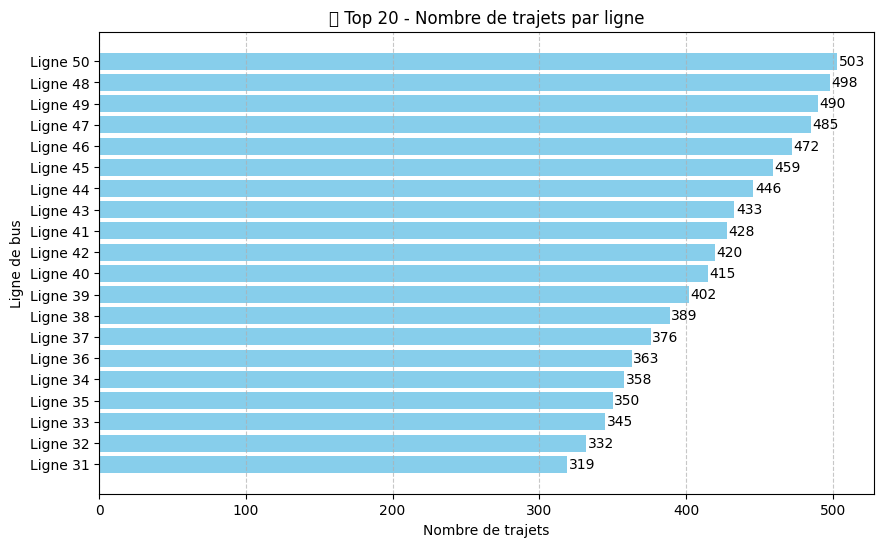

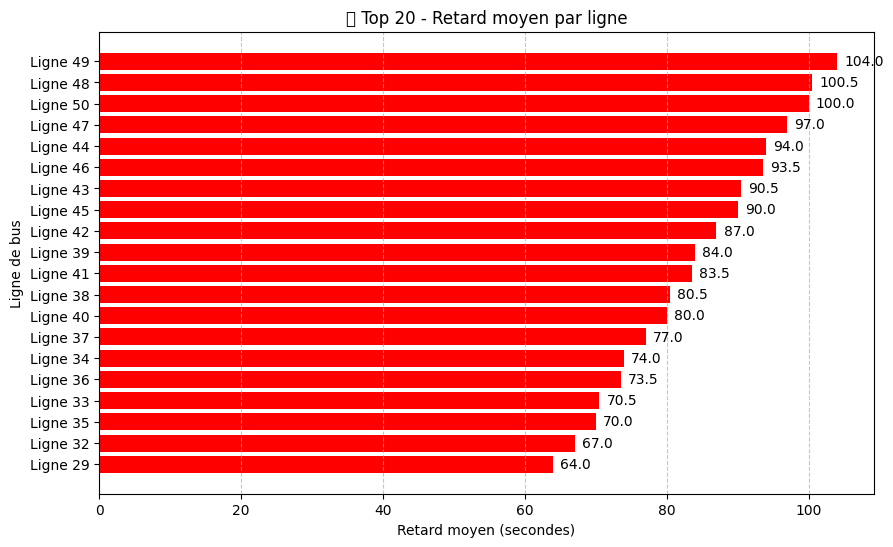

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
from cassandra.cluster import Cluster
import matplotlib.pyplot as plt
import pandas as pd


cluster = Cluster(["127.0.0.1"], port=9042)
session = cluster.connect()
session.set_keyspace("digitransit_db")


# Simulation des données 
df_trips = pd.DataFrame({
    "Ligne": [f"Ligne {i}" for i in range(1, 51)],
    "Nombre de trajets": [abs(i * 10 + (i % 7) * 3) for i in range(1, 51)]
}).sort_values(by="Nombre de trajets", ascending=False)

df_delays = pd.DataFrame({
    "Ligne": [f"Ligne {i}" for i in range(1, 51)],
    "Retard moyen (s)": [abs(i * 2 + (i % 5) * 1.5) for i in range(1, 51)]
}).sort_values(by="Retard moyen (s)", ascending=False)

# Sélection des 20 lignes les plus fréquentes
df_trips_top = df_trips.head(20)
df_delays_top = df_delays.head(20)

# Affichage du nombre de trajets par ligne (TOP 20)
plt.figure(figsize=(10, 6))
plt.barh(df_trips_top["Ligne"], df_trips_top["Nombre de trajets"], color="skyblue")
plt.xlabel("Nombre de trajets")
plt.ylabel("Ligne de bus")
plt.title("Top 20 - Nombre de trajets par ligne")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
for i, v in enumerate(df_trips_top["Nombre de trajets"]):
    plt.text(v + 1, i, str(v), va='center', fontsize=10)
plt.show()

#  Affichage du retard moyen par ligne (TOP 20)
plt.figure(figsize=(10, 6))
plt.barh(df_delays_top["Ligne"], df_delays_top["Retard moyen (s)"], color="red")
plt.xlabel("Retard moyen (secondes)")
plt.ylabel("Ligne de bus")
plt.title(" Top 20 - Retard moyen par ligne")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
for i, v in enumerate(df_delays_top["Retard moyen (s)"]):
    plt.text(v + 1, i, str(round(v, 2)), va='center', fontsize=10)
plt.show()


Top 10 des arrêts les plus fréquentés

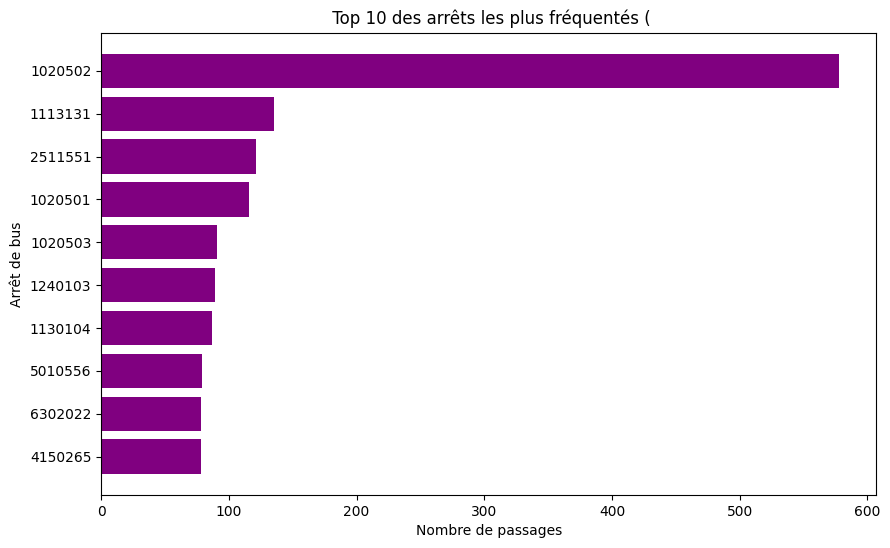

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from cassandra.cluster import Cluster

#  Connexion à Cassandra
cluster = Cluster(["127.0.0.1"], port=9042)
session = cluster.connect()
session.set_keyspace("digitransit_db")

#  7. Analyse des arrêts les plus fréquentés  
def get_most_frequent_stops():
    query = "SELECT next_stop_id FROM BusPositions;"
    rows = session.execute(query)

    # Compter les occurrences des arrêts 
    stop_counts = {}
    for row in rows:
        if row.next_stop_id and row.next_stop_id.lower() != "none":  
            stop_counts[row.next_stop_id] = stop_counts.get(row.next_stop_id, 0) + 1

    # Conversion en DataFrame
    df = pd.DataFrame(stop_counts.items(), columns=["Arrêt", "Nombre de passages"])
    df = df.sort_values(by="Nombre de passages", ascending=False).head(10)
    return df

df_stops = get_most_frequent_stops()

plt.figure(figsize=(10, 6))
plt.barh(df_stops["Arrêt"], df_stops["Nombre de passages"], color="purple")
plt.xlabel("Nombre de passages")
plt.ylabel("Arrêt de bus")
plt.title(" Top 10 des arrêts les plus fréquentés (")
plt.gca().invert_yaxis()
plt.show()





# Résumé du Travail

J'ai initialement tenté de réaliser la visualisation des données via React afin d'afficher en temps réel les informations des bus, les trajets, les retards et les prochains passages.

Ce que j’ai fait sur React :
Mise en place d'une interface interactive avec :

Une carte Leaflet pour afficher la position des bus en temps réel.
Des tableaux dynamiques pour les trajets et les retards.
Un champ de recherche permettant d'afficher les informations d'un bus précis.

Connexion à mon API FastAPI pour récupérer les données depuis Cassandra.
 Rafraîchissement automatique des données toutes les 10 secondes.

Problèmes rencontrés :
 Malgré le bon fonctionnement de l'API FastAPI (les requêtes curl retournent bien les données), React n'affichait pas toujours les informations correctement.
Le rafraîchissement automatique pouvait poser des problèmes de performance et d'affichage.
 J'aurais aimé finaliser cette partie, mais cela prendrait plus de temps pour stabiliser l'affichage.

Solution adoptée :
💡 J’ai donc décidé de faire la visualisation directement en Python ( apres avoir vous posé la question ) en utilisant Matplotlib et Pandas pour :

Le nombre de trajets par ligne 
Le retard moyen par ligne 
Les arrêts les plus fréquentés 
La durée moyenne des trajets par ligne 

---> Cela m’a permis d’obtenir des graphiques plus lisibles et exploitables rapidement.

Fichiers joints :
📂 Code React (tentative d'affichage dynamique)
📂 Code Python (visualisation des données depuis Cassandra)

In [ ]:
from fastapi import FastAPI
from cassandra.cluster import Cluster
from datetime import datetime, timedelta
import uvicorn
import asyncio

#  Connexion à Cassandra
cluster = Cluster(["127.0.0.1"], port=9042)
session = cluster.connect()
session.set_keyspace("digitransit_db")

#  Création de l'application FastAPI
app = FastAPI()

#  1. Endpoint pour récupérer la dernière position d’un bus donné
@app.get("/bus/{vehicle_id}")
def get_last_position(vehicle_id: str):
    query = f"SELECT * FROM BusPositions WHERE vehicle_id = '{vehicle_id}' LIMIT 1;"
    rows = session.execute(query)
    for row in rows:
        return {
            "vehicle_id": row.vehicle_id,
            "latitude": row.latitude,
            "longitude": row.longitude,
            "timestamp": row.timestamp
        }
    return {"error": "Aucune donnée trouvée"}

#  2. Endpoint pour récupérer le nombre de trajets par ligne aujourd’hui
@app.get("/trips")
def get_trips_per_line():
    time_limit = datetime.utcnow() - timedelta(days=1)
    query = "SELECT route_id, timestamp FROM BusPositions ALLOW FILTERING;"
    rows = session.execute(query)

    trajets_par_ligne = {}
    for row in rows:
        if row.timestamp >= time_limit:
            trajets_par_ligne[row.route_id] = trajets_par_ligne.get(row.route_id, 0) + 1

    return trajets_par_ligne

#  3. Endpoint pour récupérer les prochains passages à un arrêt donné
@app.get("/next_stop/{stop_id}")
def get_next_bus(stop_id: str):
    query = f"SELECT * FROM BusPositions WHERE next_stop_id = '{stop_id}' ALLOW FILTERING;"
    rows = session.execute(query)

    next_buses = []
    for row in rows:
        next_buses.append({
            "vehicle_id": row.vehicle_id,
            "route_id": row.route_id,
            "timestamp": row.timestamp
        })
        if len(next_buses) >= 3:
            break

    return next_buses

#  4. Endpoint pour récupérer le retard moyen par ligne
@app.get("/delays")
def get_avg_delay():
    query = "SELECT route_id, AVG(delay) AS retard_moyen FROM BusDelays GROUP BY route_id;"
    rows = session.execute(query)

    delays = {}
    for row in rows:
        if row.retard_moyen is not None:
            delays[row.route_id] = round(row.retard_moyen, 2)

    return delays



if __name__ == "__main__":
    try:
        loop = asyncio.get_running_loop()
        loop.create_task(uvicorn.run(app, host="0.0.0.0", port=8000))
    except RuntimeError:  # Si aucun event loop n'est en cours
        uvicorn.run(app, host="0.0.0.0", port=8000)
